In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)
    return model, df, model_confusion

def performance_metrics_recorder(predictions, y_test, df, model_name):
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name, model_accuracy_score, model_precision_score, model_recall_score, model_f1_score, model_roc_auc]
    return df, model_confusion

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    if isinstance(model, DecisionTree):
        feature_importance = model.feature_importances_
    elif isinstance(model, RandomForest):
        feature_importance = np.mean([tree.feature_importances_ for tree in model.trees], axis=0)
    else:
        raise ValueError("Unsupported model type. Supported types are DecisionTree and RandomForest.")

    features_list = X.columns.values
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid:
        plt.grid(alpha=0.5)
    plt.show()

def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(), 
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

In [3]:
# reading the raw CSV data file
df = pd.read_csv("Dataset/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# finding columns in the df which have any null/na values
np.where(pd.isna(df))

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# Checking the missing values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [6]:
# getting the shape of the dataset
df.shape

(8124, 23)

In [7]:
# getting info on the columns of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [8]:
# getting statistical descriptions of the df
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


In [10]:
# creating a copy of the original dataframe
df2 = df.copy()

In [11]:
# performing Label Encoding on each of the 23 features
for col in df2.columns:
    le = LabelEncoder()
    le.fit(df2[col])
    df2[col] = le.transform(df2[col])
    if col == 'class':
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

{'e': 0, 'p': 1}


In [12]:
# check to see counts for each class
counts = df2['class'].value_counts()
print(counts)

class
0    4208
1    3916
Name: count, dtype: int64


In [13]:
# checking ratio of class 'e' vs 'p'
total_counts = 4208 + 3916
print((4208/total_counts)*100) # class 0 = 'e'
print((3916/total_counts)*100) # class 1 = 'p'

51.7971442639094
48.20285573609059


In [14]:
# examining the label-encoded dataframe
df2.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [15]:
# getting correlation matrix of matrix
corr = df2.corr()
corr.style.background_gradient('coolwarm')

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\formats\style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\formats\style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [16]:
# checking the veil-type column, which has nan
df2['veil-type'].unique()

array([0])

In [17]:
# standardizing the data
df3 = df2.copy()
scaler = StandardScaler()
df3 = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [18]:
# getting correlation matrix of standardized matrix
corr = df3.corr()
corr.style.background_gradient('coolwarm')

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\formats\style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\io\formats\style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [19]:
# splitting dataset
X = df2.drop(['class'],axis=1)
Y = df2['class']

In [20]:
# creating train/test split using 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [21]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1","roc_auc"]
performance_metrics = pd.DataFrame(columns=column_names)

In [22]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None, entropy=None, value_counts=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.entropy = entropy
        self.value_counts = value_counts

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.feature_importances_ = np.zeros(X.shape[1])
        self.root = self._grow_tree(X, y)
        self.feature_importances_ /= self.feature_importances_.sum()  # Normalize importances

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value, entropy=self._entropy(y), value_counts=dict(Counter(y)))

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feature is not None:
            left_idxs, right_idxs = self._split(X.iloc[:, best_feature], best_thresh)
            left = self._grow_tree(X.iloc[left_idxs, :], y.iloc[left_idxs], depth + 1)
            right = self._grow_tree(X.iloc[right_idxs, :], y.iloc[right_idxs], depth + 1)
            self.feature_importances_[best_feature] += self._information_gain(y, X.iloc[:, best_feature], best_thresh)
            return Node(best_feature, best_thresh, left, right, entropy=self._entropy(y),
                        value_counts=dict(Counter(y)))

        leaf_value = self._most_common_label(y)
        return Node(value=leaf_value, entropy=self._entropy(y), value_counts=dict(Counter(y)))

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        left_labels = y.iloc[left_idxs]
        right_labels = y.iloc[right_idxs]

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(left_labels), self._entropy(right_labels)
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        if isinstance(split_thresh, str):
            left_idxs = np.where(X_column == split_thresh)[0]
            right_idxs = np.where(X_column != split_thresh)[0]
        else:
            left_idxs = np.argwhere(X_column <= split_thresh).flatten()
            right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        y_values = y.values if isinstance(y, pd.Series) else y
        hist = np.bincount(y_values)
        ps = hist / len(y_values)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X.to_numpy()])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if node.feature >= len(x):
            return node.value

        if isinstance(node.threshold, str):
            if x[node.feature] == node.threshold:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)
        else:
            if isinstance(x[node.feature], str):
                if x[node.feature] == node.threshold:
                    return self._traverse_tree(x, node.left)
                else:
                    return self._traverse_tree(x, node.right)
            else:
                if x[node.feature] <= node.threshold:
                    return self._traverse_tree(x, node.left)
                else:
                    return self._traverse_tree(x, node.right)
    def plot_tree(self):
        plt.figure(figsize=(20, 10))
        self._plot_tree_recursive(self.root, x_offset=0.5, y_offset=1, indent=0, level=0, width=1.0)
        plt.show()

    def _plot_tree_recursive(self, node, x_offset, y_offset, indent, level, width):
        if node is None:
            return

        if node.is_leaf_node():
            plt.text(x_offset, y_offset, f"Class {node.value}\nEntropy: {node.entropy:.2f}\nValue: {node.value_counts}", ha='center', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))
            return

        plt.text(x_offset, y_offset, f"X[{node.feature}] <= {node.threshold}\nEntropy: {node.entropy:.2f}\nValue: {node.value_counts}", ha='center', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))
        if node.left is not None:
            plt.plot([x_offset, x_offset - 0.1 * width], [y_offset - 0.1, y_offset - 1], '-k')
            new_x_offset = x_offset - 0.1 * width
            self._plot_tree_recursive(node.left, new_x_offset, y_offset - 1, indent + 1, level + 1, width * 0.8)  # Adjust width here
        if node.right is not None:
            plt.plot([x_offset, x_offset + 0.1 * width], [y_offset - 0.1, y_offset - 1], '-k')
            new_x_offset = x_offset + 0.1 * width
            self._plot_tree_recursive(node.right, new_x_offset, y_offset - 1, indent + 1, level + 1, width * 0.8)  # Adjust width here

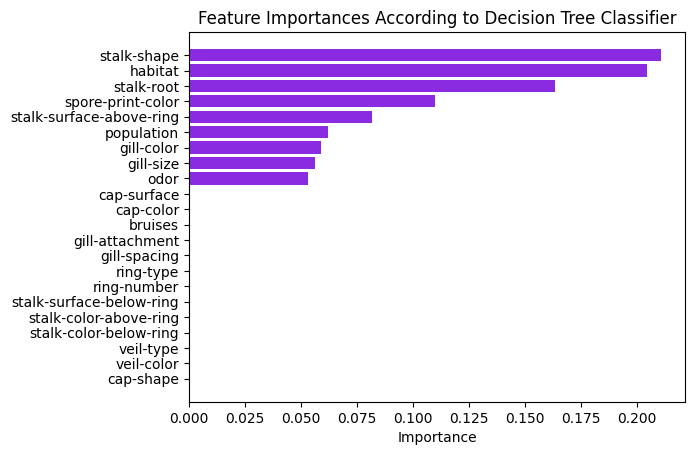

In [23]:
# Decision Tree
label = "Decision Tree"
dt = DecisionTree()
dt, performance_metrics, dt_confusion = model_predictions(dt, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, dt, label, color="blueviolet")

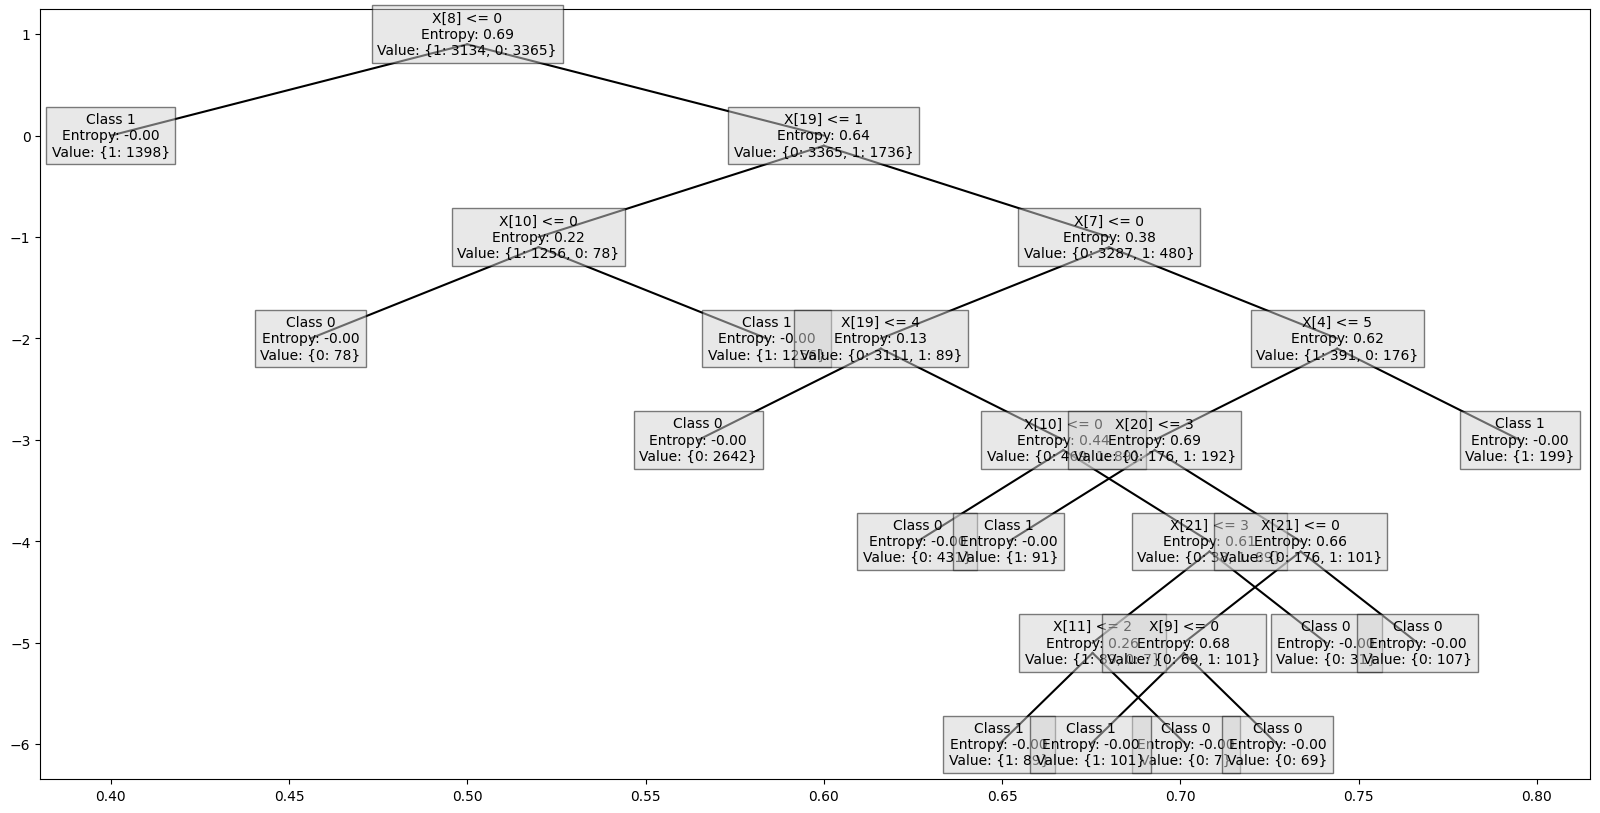

In [24]:
# also plotting decision tree
dt.plot_tree()

In [25]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X.iloc[idxs], y.iloc[idxs]


    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

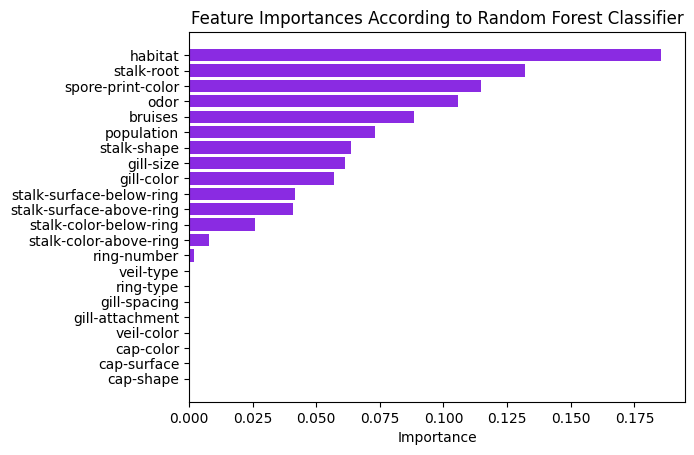

In [26]:
# Random Forest
label = "Random Forest"
rf = RandomForest()
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")